In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import imghdr
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


/tmp/ipython-input-1-778751628.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# ✅ 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/train'  # folder should contain subfolders for each note
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Removing:', image_path)
                os.remove(image_path)
        except Exception as e:
            print('Issue with image:', image_path)


Removing: /content/drive/MyDrive/train/LKR 500/Sri-Lankan-Currency-Banknote-500-Rupees-1.webp
Removing: /content/drive/MyDrive/train/LKR 20/Sri-Lankan-Currency-Banknote-20-Rupees-1.webp
Removing: /content/drive/MyDrive/train/LKR 20/sri-lanka-20-rupees-bank-note-39651550-jpg.webp
Removing: /content/drive/MyDrive/train/LKR 20/20-twenty-sri-lanka-rupees-footage-273914106_iconl.jpeg
Removing: /content/drive/MyDrive/train/LKR 20/kajaruban-kanagaratnam-eb168c49804643-58bf0f577b93f.gif
Removing: /content/drive/MyDrive/train/LKR 50/Sri-Lankan-Currency-Banknote-50-Rupees-1.webp
Removing: /content/drive/MyDrive/train/LKR 50/Sri-Lanka-50-Rupees-P-98-1989-Kelaniya-Temple.webp
Removing: /content/drive/MyDrive/train/LKR 50/orange-ten-rupee-bill-india-paired-blue-white-fifty-rupee-ba.jpg
Removing: /content/drive/MyDrive/train/LKR 50/image.webp
Removing: /content/drive/MyDrive/train/LKR 50/sri-lanka-currency-close-up-macro-view-rupees-bill-detail-sr.jpg
Removing: /content/drive/MyDrive/train/LKR 50/20

In [4]:
import cv2
img = cv2.imread(os.path.join(data_dir,'LKR 500','58753_A.jpg'))
img.shape

(479, 1024, 3)

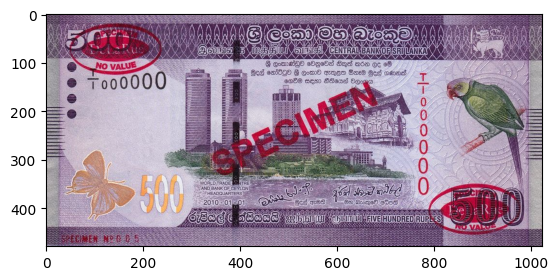

In [5]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (256, 256)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())


Found 766 images belonging to 6 classes.
Found 188 images belonging to 6 classes.


In [11]:
import numpy as np
from matplotlib import pyplot as plt


In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 954 files belonging to 6 classes.


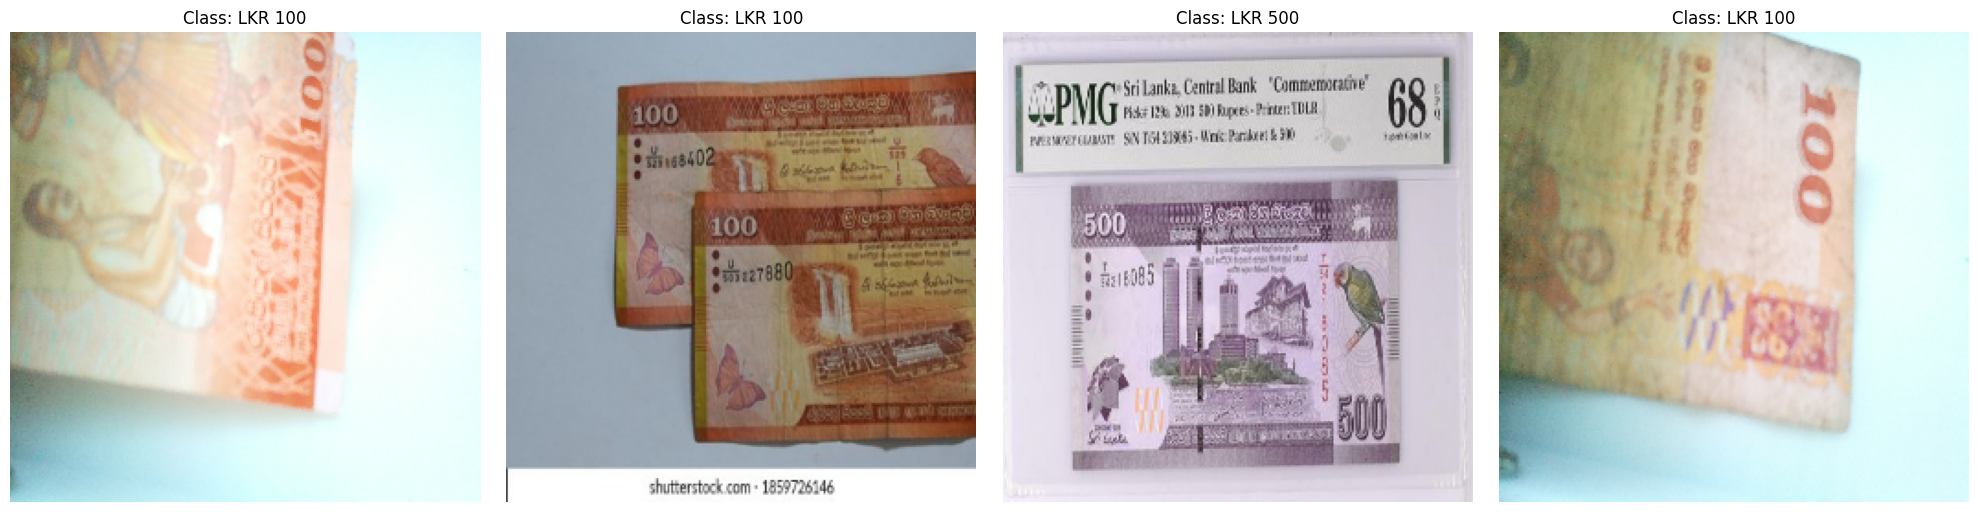

In [20]:
# Get class names from dataset
class_names = data.class_names  # e.g., ['LKR 100', 'LKR 1000', ..., 'LKR 5000']

# Get one batch from the dataset
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()  # batch[0] = images, batch[1] = labels

# Plot 4 images with class names
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    label_index = int(batch[1][idx])  # Convert to int
    ax[idx].set_title(f"Class: {class_names[label_index]}")
    ax[idx].axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Get one batch from the dataset
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()  # batch[0] = images, batch[1] = labels

# Plot 4 images with class index (e.g., 0, 1, 2...)
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    label_index = int(batch[1][idx])  # Just the integer label
    ax[idx].set_title(f"Label Index: {label_index}")
    ax[idx].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [15]:
class_names = data.class_names

print("Class Index Mapping:")
for index, name in enumerate(class_names):
    print(f"{name} → {index}")


Class Index Mapping:
LKR 100 → 0
LKR 1000 → 1
LKR 20 → 2
LKR 50 → 3
LKR 500 → 4
LKR 5000 → 5


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')  # for 6 currency classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 439,750 (1.68 MB)

 Trainable params: 439,750 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optional learning rate adjustment if performance stalls
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[reduce_lr]  # No early stopping here
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - accuracy: 0.2127 - loss: 1.7722 - val_accuracy: 0.2447 - val_loss: 1.6791 - learning_rate: 0.0010
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.2281 - loss: 1.6469 - val_accuracy: 0.3404 - val_loss: 1.5143 - learning_rate: 0.0010
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.3639 - loss: 1.5211 - val_accuracy: 0.2979 - val_loss: 1.5089 - learning_rate: 0.0010
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.3537 - loss: 1.5115 - val_accuracy: 0.3138 - val_loss: 1.3564 - learning_rate: 0.0010
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.3672 - loss: 1.4304 - val_accuracy: 0.3830 - val_loss: 1.3080 - learning_rate: 0.0010
Epoch 6/30
11/24 ━━━━━━━━━━━━━━━━━━━━ 1:12 6s/step - accuracy: 0.4021 - loss: 1.3552

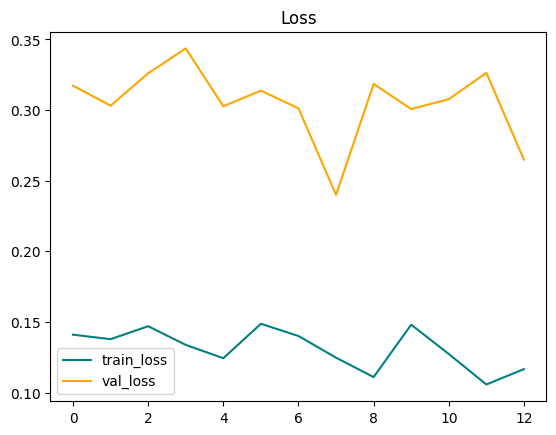

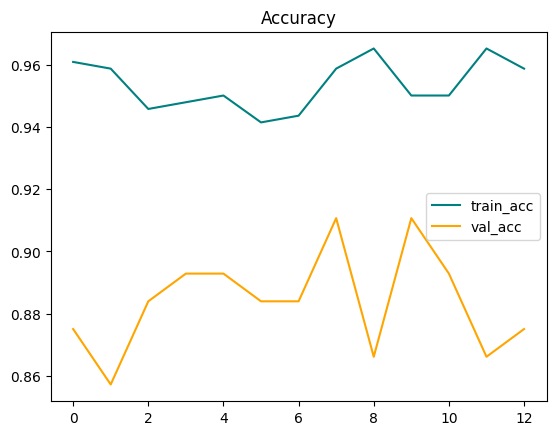

In [ ]:
# Loss
plt.plot(hist.history['loss'], label='train_loss', color='teal')
plt.plot(hist.history['val_loss'], label='val_loss', color='orange')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(hist.history['accuracy'], label='train_acc', color='teal')
plt.plot(hist.history['val_accuracy'], label='val_acc', color='orange')
plt.title('Accuracy')
plt.legend()
plt.show()


3/4 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
              precision    recall  f1-score   support

     LKR 100       0.27      0.27      0.27        26
    LKR 1000       0.22      0.25      0.24        16
      LKR 20       0.21      0.21      0.21        24
      LKR 50       0.24      0.22      0.23        18
     LKR 500       0.20      0.21      0.21        14
    LKR 5000       0.00      0.00      0.00        14

    accuracy                           0.21       112
   macro avg       0.19      0.19      0.19       112
weighted avg       0.20      0.21      0.20       112



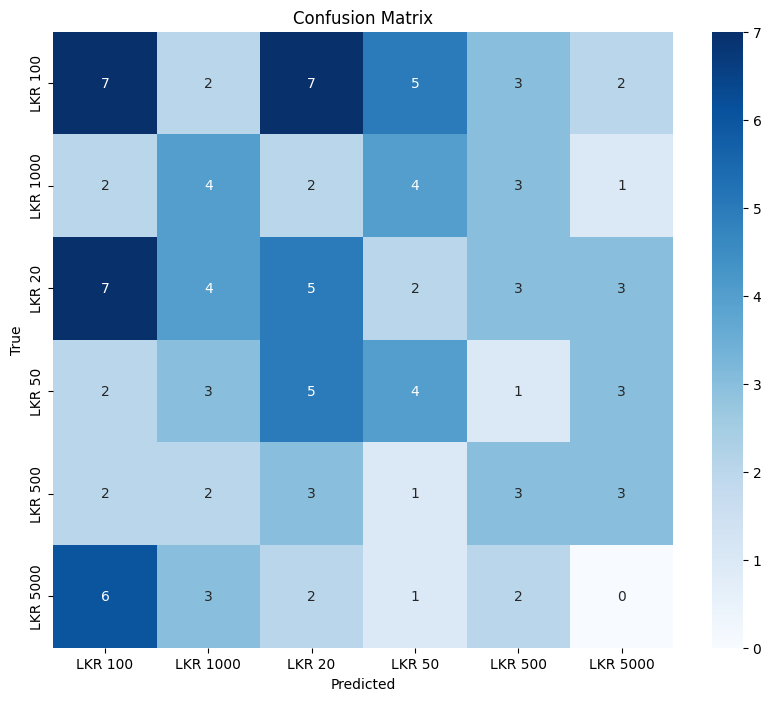

In [ ]:
val_generator.reset()

y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save
model.save('/content/drive/MyDrive/currency.h5')

